In [ ]:
import pandas as pd
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 


In [ ]:
col_names = ['idx1', 'idx2', 'Id', 'EventTimeStamp', 'EquipmentID', 'DriverID', 'Latitude',
       'Longitude', 'LocationTimeStamp', 'Speed', 'Odometer', 'IgnitionStatus',
       'EFReportReason', 'TankLevelPercent', 'TankLevelGallons',
       'ExactFuelEventId', 'truck', 'tankcap', 'refuel_datetime',
       'refuel_tr_sum', 'refuel_tr_id']
date_cols = ['EventTimeStamp', 'LocationTimeStamp', 'refuel_datetime' ]

In [ ]:
dtype_dict = {
    'Id' : 'uint64', 
    'EquipmentID' : 'category', 
    'DriverID' : 'category', 
    'Latitude' : 'float64', 
    'Longitude' : 'float64', 
    'Speed' : 'uint16', 
    'Odometer' : 'float64', 
    'IgnitionStatus' : 'category', 
    'EFReportReason' : 'category', 
    'TankLevelPercent' : 'float32', 
    'TankLevelGallons' : 'float32', 
    'ExactFuelEventId' : 'uint64', 
    'truck' : 'category', 
    'tankcap' : 'uint16', 
    'refuel_tr_sum' : 'float32', 
    'refuel_tr_id' : 'category' }

In [ ]:
#bigdata = pd.read_csv('big_files/events_levels_df.gz')
events_levels_df = pd.read_csv('big_files/events_levels_df.gz', skiprows=1, names=col_names,
                               dtype=dtype_dict, usecols=np.arange(2,21), 
                              parse_dates = date_cols, infer_datetime_format = True)

In [ ]:
events_levels_df.info()


In [ ]:
events_levels_df.head(5)

In [ ]:
len(set(events_levels_df['truck'])) # there are 629 trucks  

In [ ]:
# drop duplicates columns ... EquipmentId (truck is available)
#events_levels_df.drop('EquipmentID',inplace=True,axis= 'columns')
#events_levels_df.info()


In [ ]:
events_levels_df.sort_values(['truck','EventTimeStamp'],inplace=True)

In [ ]:
events_levels_df.head(25)

In [ ]:
events_levels_df.reset_index(inplace=True,drop=True)

In [ ]:
events_levels_df.head(5)

In [ ]:
#fn need df whose index is reset...
# lets try to optimize the performance of the flagging function
def flag_anomal_odom_rows_2(df):#!!!! requires a dataframe with a reset index!!!!
    '''takes a dataframe with an Odometer column and returns a boolean index of 
    identifying which rows are noisy Odometer readings and should be dropped.
    '''
    #initialize a series, without attaching it to the df in the hopes of expediency
    OdomDiff = df.Odometer.diff()
    #initialize list which will serve as a boolean index
    flags = []
    flag = 1 #this will be flipped like a switch 1 means do not drop, 0 means drop
    #loop through each difference measurement
    for i in range(len(OdomDiff) - 1):
    # the loop will flag all but the last row because otherwise I'd have to find a way to loop around the "corner" of the index
        #will start by flaggin with 1 (do not drop) until an anomaly flips it.
        flags.append(bool(flag))
    #   # for each truck, if odometer change is anomalous (i.e. spikes up or down) flip the flag switch
        if (df.truck[i + 1] == df.truck[i]) & (abs(OdomDiff[i + 1]) > 200): 
            flag = (flag + 1)%2
    #       #the flag will remain on the delete (i.e. 0) setting until the loop detects the spike that corrects the odometer
    #   # if we change trucks before the anomaly is corrected reset the flag to do not drop (i.e. 1)   
        if df.truck[i + 1] != df.truck[i]:
            flag = 1
    #now that the loop is done, we append the last flag (which is in the state the loop left it. So, if a loop ends before the anomaly is corrected, the flag will still be set at 0/False)
    flags.append(bool(flag))
    return flags

In [ ]:
#identifying the rows in merged_big data which are noisey and raising a flag for spikey odometer readings....
#flags = flag_anomal_odom_rows_2(events_levels_df)

In [ ]:
#got the ids with high odometer readings as a csv and removed those rows from the data
bad_ids = pd.read_csv('bad_ids.csv', header=None, names=['Id']).Id.tolist()
# Create boolean series to remove rows with bad odometer readings
keep_ids = events_levels_df.Id.isin(bad_ids) == False

In [ ]:
len(bad_ids)  # there are 411 bad -id's in df

In [ ]:
#dropping the noisey data--rows
t0 = datetime.now()
print('started at ', datetime.now())
events_levels_df = events_levels_df[keep_ids]
tf = datetime.now()
print('finished at ', tf)
print('whole process took ', tf-t0)
print('')
events_levels_df.info(memory_usage='deep', null_counts=True)
#events_levels_df = events_levels_df[flags]

In [ ]:
events_levels_df.head(5)


In [ ]:
events_grp =events_levels_df[['DriverID', 'EventTimeStamp', 'EquipmentID','Odometer', 'refuel_tr_id', 'refuel_tr_sum', 
                              'refuel_datetime']].groupby(['DriverID', 'EquipmentID', 'refuel_datetime'])

In [ ]:
events_grp.head(5)

In [ ]:


agg_dict = {'Odometer' : ['min', 'max'], 
           'EventTimeStamp' : ['first', 'last'], 
           'refuel_tr_id' : 'first', 
           'refuel_tr_sum' : 'first'}
events_grp_df = events_grp.agg(agg_dict)

events_grp_df.info(memory_usage='deep', null_counts=True)

In [ ]:
(233502.4 - 233185.1 ) / 6

In [ ]:
events_grp_df.head(100)

In [ ]:
events_grp_df.index.names

In [ ]:
#events_grp_df.index.value_counts

In [139]:
df_albme = events_grp_df.loc['ALBME']

In [140]:
df_albme.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 177 entries, (1549, 2017-03-09 16:10:00) to (1696, 2018-03-23 04:44:00)
Data columns (total 6 columns):
(Odometer, min)            177 non-null float64
(Odometer, max)            177 non-null float64
(EventTimeStamp, first)    177 non-null datetime64[ns]
(EventTimeStamp, last)     177 non-null datetime64[ns]
(refuel_tr_id, first)      177 non-null object
(refuel_tr_sum, first)     177 non-null float32
dtypes: datetime64[ns](2), float32(1), float64(2), object(1)
memory usage: 737.9+ KB


In [141]:
df_albme.head(5)

Odometer                    EventTimeStamp  \
                                      min       max                   first   
EquipmentID refuel_datetime                                                   
1549        2017-03-09 16:10:00  573032.8  573047.2 2017-03-09 12:15:39.150   
            2017-03-10 12:50:00  573047.2  573439.0 2017-03-09 16:12:43.197   
            2017-03-12 08:57:00  573439.0  574097.8 2017-03-10 12:52:33.767   
            2017-03-13 17:16:00  574097.8  574878.9 2017-03-12 08:59:28.373   
            2017-03-15 14:52:00  574878.9  575598.6 2017-03-13 17:17:46.927   

                                                        refuel_tr_id  \
                                                   last        first   
EquipmentID refuel_datetime                                            
1549        2017-03-09 16:10:00 2017-03-09 16:03:32.933     50652608   
            2017-03-10 12:50:00 2017-03-10 12:49:13.767     50763815   
            2017-03-12 08:57:00 2017-03-12 08:53:58.390     50936237   
            2017-03-13 17:16:00 2017-03-13 17:13:46.990     51097381   
            2017-03-15 14:52:00 2017-03-15 14:46:54.633     51352330   

                                refuel_tr_sum  
                                        first  
EquipmentID refuel_datetime                    
1549        2017-03-09 16:10:00    124.949997  
            2017-03-10 12:50:00     54.000000  
            2017-03-12 08:57:00    128.369995  
            2017-03-13 17:16:00    111.550003  
            2017-03-15 14:52:00    128.820007

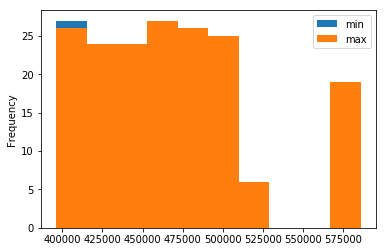

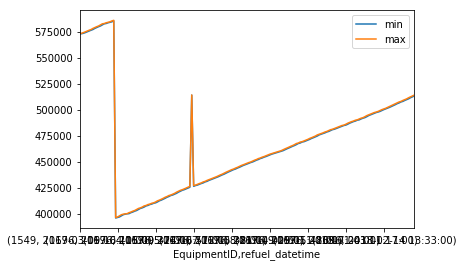

In [142]:

#fig, axes = plt.subplots(nrows=2, ncols=1)
df_albme.Odometer.plot(kind='hist');
df_albme.Odometer.plot();
plt.show()

In [ ]:
#sns.factorplot(x='EquipmentID', y='Odometer', data=df_albme)
#plt.show()

In [ ]:
#df = df.stack(cols).reset_index(cols).rename(columns={0: 'value'})
#df.info()
#sns.swarmplot(x='EquipmentId', y='Odometer',data=df_albme)
#plt.show()

In [143]:
df_adag.head(5)

Odometer                    EventTimeStamp  \
                                      min       max                   first   
EquipmentID refuel_datetime                                                   
1857        2017-01-02 09:02:00  148320.0  148476.9 2017-05-27 13:34:21.547   
            2017-03-04 13:49:00  119691.4  120131.4 2017-03-03 14:09:02.890   
            2017-03-06 14:28:00  120131.4  120700.9 2017-03-04 13:50:55.077   
            2017-03-08 06:41:00  120701.5  121328.8 2017-03-06 14:37:36.750   
            2017-03-10 04:35:00  121328.8  122230.4 2017-03-08 06:43:46.187   

                                                        refuel_tr_id  \
                                                   last        first   
EquipmentID refuel_datetime                                            
1857        2017-01-02 09:02:00 2017-05-28 07:41:34.123     42641419   
            2017-03-04 13:49:00 2017-03-04 13:40:35.017     50015035   
            2017-03-06 14:28:00 2017-03-06 14:24:36.703     50205363   
            2017-03-08 06:41:00 2017-03-08 06:34:26.140     50425832   
            2017-03-10 04:35:00 2017-03-10 04:28:16.233     50708256   

                                refuel_tr_sum  
                                        first  
EquipmentID refuel_datetime                    
1857        2017-01-02 09:02:00     65.000000  
            2017-03-04 13:49:00    124.010002  
            2017-03-06 14:28:00     80.120003  
            2017-03-08 06:41:00    102.029999  
            2017-03-10 04:35:00     70.010002

In [156]:
df_adag = events_grp_df.loc['ADAG']

In [158]:
df_adag.loc['1857']

Odometer                    EventTimeStamp  \
                          min       max                   first   
refuel_datetime                                                   
2017-01-02 09:02:00  148320.0  148476.9 2017-05-27 13:34:21.547   
2017-03-04 13:49:00  119691.4  120131.4 2017-03-03 14:09:02.890   
2017-03-06 14:28:00  120131.4  120700.9 2017-03-04 13:50:55.077   
2017-03-08 06:41:00  120701.5  121328.8 2017-03-06 14:37:36.750   
2017-03-10 04:35:00  121328.8  122230.4 2017-03-08 06:43:46.187   
2017-03-13 09:30:00  122230.5  122827.7 2017-03-10 04:40:36.233   
2017-03-15 08:20:00  122827.7  123750.8 2017-03-13 09:32:07.827   
2017-03-15 15:53:00  123750.8  124046.6 2017-03-15 08:22:57.620   
2017-03-17 17:20:00  124046.6  124799.8 2017-03-15 15:55:00.243   
2017-03-20 15:31:00  124799.8  125621.1 2017-03-17 17:34:27.703   
2017-03-22 13:25:00  125621.1  126448.5 2017-03-20 15:32:47.603   
2017-03-24 04:48:00  126449.3  127212.8 2017-03-22 13:28:54.470   
2017-03-28 14:38:00  127213.5  128243.5 2017-03-24 04:52:43.177   
2017-03-30 16:11:00  128243.5  129273.7 2017-03-28 14:40:27.197   
2017-04-02 12:52:00  129275.0  129599.3 2017-03-30 16:19:31.753   
2017-04-05 12:08:00  129599.3  130799.0 2017-04-02 12:59:48.577   
2017-04-10 17:00:00  130799.9  132075.3 2017-04-05 12:11:24.947   
2017-04-12 13:54:00  132075.4  133193.9 2017-04-10 17:01:56.970   
2017-04-16 21:26:00  133193.9  134339.7 2017-04-12 13:56:33.473   
2017-04-19 10:07:00  134340.8  135199.1 2017-04-16 21:41:54.730   
2017-04-21 02:59:00  135199.1  136139.1 2017-04-19 10:07:11.107   
2017-04-25 09:45:00  136139.1  137083.5 2017-04-21 03:05:12.407   
2017-04-26 14:06:00  137083.5  137884.8 2017-04-25 09:47:08.267   
2017-04-27 12:14:00  137885.3  138421.3 2017-04-26 14:10:24.407   
2017-05-01 13:06:00  138421.3  139266.4 2017-04-27 12:15:43.797   
2017-05-02 06:40:00  139266.5  139537.2 2017-05-01 13:10:14.343   
2017-05-03 10:42:00  139538.6  140201.1 2017-05-02 06:51:38.827   
2017-05-05 08:12:00  140201.1  141012.2 2017-05-03 10:44:29.483   
2017-05-07 19:21:00  141012.6  142004.4 2017-05-05 08:16:10.610   
2017-05-08 13:09:00  142004.4  142239.3 2017-05-07 19:21:15.687   
2017-05-10 07:13:00  142239.3  143155.4 2017-05-08 13:11:01.290   
2017-05-11 19:27:00  143155.4  144042.1 2017-05-10 07:16:07.110   
2017-05-15 13:35:00  144042.2  144793.1 2017-05-11 19:29:00.467   
2017-05-17 06:33:00  144793.1  145582.3 2017-05-15 13:37:36.653   
2017-05-18 10:51:00  145582.3  145886.6 2017-05-17 06:34:39.827   
2017-05-23 10:28:00  145888.0  146756.3 2017-05-18 10:54:33.917   
2017-05-25 12:40:00  146756.4  147745.2 2017-05-23 10:33:08.400   
2017-05-27 13:29:00  147745.2  148319.1 2017-05-25 12:42:18.220   

                                            refuel_tr_id refuel_tr_sum  
                                       last        first         first  
refuel_datetime                                                         
2017-01-02 09:02:00 2017-05-28 07:41:34.123     42641419     65.000000  
2017-03-04 13:49:00 2017-03-04 13:40:35.017     50015035    124.010002  
2017-03-06 14:28:00 2017-03-06 14:24:36.703     50205363     80.120003  
2017-03-08 06:41:00 2017-03-08 06:34:26.140     50425832    102.029999  
2017-03-10 04:35:00 2017-03-10 04:28:16.233     50708256     70.010002  
2017-03-13 09:30:00 2017-03-13 09:24:37.767     51033610    147.059998  
2017-03-15 08:20:00 2017-03-15 08:13:57.587     51297538     50.000000  
2017-03-15 15:53:00 2017-03-15 15:44:30.210     51361348    116.010002  
2017-03-17 17:20:00 2017-03-17 17:11:37.577     51661618    126.019997  
2017-03-20 15:31:00 2017-03-20 15:22:17.477     51940654    128.000000  
2017-03-22 13:25:00 2017-03-22 13:15:24.360     52207787    130.009995  
2017-03-24 04:48:00 2017-03-24 04:41:33.300     52442201    106.029999  
2017-03-28 14:38:00 2017-03-28 14:32:27.117     52947874    141.020004  
2017-03-30 16:11:00 2017-03-30 16:03:21.720     53257339     54.009998  
2017-04-02 12:52:00 2017-04-02 1

In [160]:
events_grp.head()

,DriverID,EventTimeStamp,EquipmentID,Odometer,refuel_tr_id,refuel_tr_sum,refuel_datetime
0,NaN,2017-01-09 08:03:30.687,1508,575630.9,NaN,NaN,NaT
1,NaN,2017-01-09 08:05:30.670,1508,575630.9,NaN,NaN,NaT
2,NaN,2017-01-09 08:17:10.670,1508,575631.0,NaN,NaN,NaT
3,NaN,2017-01-09 12:24:31.170,1508,575631.0,NaN,NaN,NaT
4,NaN,2017-01-09 12:25:41.203,1508,575631.0,NaN,NaN,NaT
15,BAIJO,2017-01-01 08:12:27.390,1513,529067.8,42598121,50.020000,2017-01-01 12:11:00
16,BAIJO,2017-01-01 08:14:27.390,1513,529067.8,42598121,50.020000,2017-01-01 12:11:00
17,BAIJO,2017-01-01 08:29:37.403,1513,529067.8,42598121,50.020000,2017-01-01 12:11:00
18,BAIJO,2017-01-01 08:30:47.403,1513,529067.8,42598121,50.020000,2017-01-01 12:11:00
19,BAIJO,2017-01-01 12:05:57.983,1513,529067.8,42598121,50.020000,2017-01-01 12:11:00


In [169]:
events_grp_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 101112 entries, (ABBV, 1821, 2017-03-04 13:49:00) to (ZAMJ, 1588, 2017-06-01 08:14:00)
Data columns (total 6 columns):
(Odometer, min)            101112 non-null float64
(Odometer, max)            101112 non-null float64
(EventTimeStamp, first)    101112 non-null datetime64[ns]
(EventTimeStamp, last)     101112 non-null datetime64[ns]
(refuel_tr_id, first)      101078 non-null object
(refuel_tr_sum, first)     101112 non-null float32
dtypes: datetime64[ns](2), float32(1), float64(2), object(1)
memory usage: 5.8+ MB


In [168]:
df_bevl_310 = events_grp_df[(events_grp_df.DriverID == 'BEVL') & (events_grp_df.EquipmentID == 310)]
#fuel_trans_df[(fuel_trans_df.tr_drvr_code == 'CRAMI') & (fuel_trans_df.tr_datetime=='2017-02-14 16:15:00')] 

AttributeError: 'DataFrame' object has no attribute 'DriverID'